# Building time series forecasting models with FB Prophet.

#### Build one model for everall renewable production, one model predicting solar power production, and one model using solar power production predictions as an extra regressor for the overall renewable production model.   Finally one model for predicting total energy demand per hour.  

Assumptions made here, like defining and "On" and "Off" season were made through observations in the "Data Analysis and Visualization" notebook in this folder.



Import needed packages, create conection to database, and read source data into dataframes.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from sqlalchemy import create_engine
from config import username, password

engine = create_engine('postgresql://{}:{}@localhost:5432/cali-renewable-db'.format(username,password))
con = engine.connect()

sql_prod = '''Select * From  "Production".hourlyrenewable'''

full_data = pd.read_sql(sql=sql_prod,con=con)
full_data['date'] = pd.to_datetime(full_data['date'])

display(full_data.head())

sql_demand = 'Select * From "Demand".hourlydemand'
demand_data = pd.read_sql(sql=sql_demand, con=con)

demand_data['date'] = pd.to_datetime(demand_data['date'])
demand_data['YEAR'] = demand_data['date'].dt.year

demand_data.head()

timestamp       date  Hour  TOTAL  SOLAR TOTAL  SOLAR PV  \
0 2015-06-01 00:00:00 2015-06-01     1   4669            0         0   
1 2015-06-01 01:00:00 2015-06-01     2   4396            0         0   
2 2015-06-01 02:00:00 2015-06-01     3   4197            0         0   
3 2015-06-01 03:00:00 2015-06-01     4   4059            0         0   
4 2015-06-01 04:00:00 2015-06-01     5   3694            0         0   

   SOLAR THERMAL  WIND TOTAL  GEOTHERMAL  BIOMASS  BIOGAS  SMALL HYDRO  
0              0        2942        1038      321     209          159  
1              0        2708        1040      316     210          122  
2              0        2509        1039      319     209          121  
3              0        2372        1035      320     209          123  
4              0        1973        1035      317     208          161

timestamp       date  Hour   DEMAND  YEAR
0 2019-12-29 11:00:00 2019-12-29    11  21305.0  2019
1 2019-12-29 10:00:00 2019-12-29    10  21638.0  2019
2 2019-12-29 09:00:00 2019-12-29     9  21745.0  2019
3 2019-12-29 08:00:00 2019-12-29     8  21859.0  2019
4 2019-12-29 07:00:00 2019-12-29     7  21586.0  2019

Import two machine learning libraries.

In [2]:
from fbprophet import Prophet
from sklearn.preprocessing import StandardScaler

Building some functions to use as boolean features for extra regressors.  Added these in over time to try and help the model predict the growth of production into 2019.  

Here I cut off the last year as a testing case for quick, iterative tuning tests.  FB Prophet has a better built in cross validation method, that uses the given model parameters to train up to a certain point, test out a certain horizon, calculate accuracy metrics, then repeats the process with a longer training period over and over until it's reached the end of the time series data.  This is the better way to estimate how accurate a model will be on generalized unkown data.  Method is very slow with this large data set.

Log transform the data to remove some noise in the data and remove some of the skew in the hourly production distribution.  Tried a few other transformations, but log seemed to be the most effective simple solution.

Format training data into expected dataframe (ds, y columns) for FB Prophet.

In [3]:
#still messing around with extra regressors 



full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['TOTAL']
#daily_renew = y.resample('4H').sum()
daily_renew = y
dd = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month >= 3) & (date.month <= 9)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3) & (date.month <= 9))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1
def get_year(ds):
    date = pd.to_datetime(ds)
    if date.year <= 2014:
        return -2
    elif date.year <= 2015:
        return -1
    elif date.year <= 2016:
        return 0
    elif date.year <= 2017:
        return 1
    elif date.year <= 2018:
        return 2


dd.columns = ['ds','y']

scaler = StandardScaler()

dd['cap'] = 17000
dd['cap'] = np.log(dd['cap'])

dd['on_season'] = dd['ds'].apply(on_season)
dd['off_season'] = ~dd['ds'].apply(on_season)
dd['daytime'] = dd['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd['on_seasonr'] = dd['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
dd['y'] = dd['y'].replace(0,dd['y'].median())
#dd['y'] = np.cbrt(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
dd['y'] = np.log(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_season'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd['daytime'].values
daytimev = daytimev.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd['daytime'] = scaler.fit_transform(daytimev)

dd_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2014'))&(dd['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_train.head(8))

dd_train.info()

ds         y       cap  on_season  off_season   daytime  \
0 2015-06-01 00:00:00  8.448700  9.740969       True       False -0.795932   
1 2015-06-01 01:00:00  8.388450  9.740969       True       False -0.795932   
2 2015-06-01 02:00:00  8.342125  9.740969       True       False -0.795932   
3 2015-06-01 03:00:00  8.308692  9.740969       True       False -0.795932   
4 2015-06-01 04:00:00  8.214465  9.740969       True       False -0.795932   
5 2015-06-01 05:00:00  8.228978  9.740969       True       False -0.795932   
6 2015-06-01 06:00:00  8.365905  9.740969       True       False -0.795932   
7 2015-06-01 07:00:00  8.716372  9.740969       True       False -0.795932   

   on_seasonr  
0           1  
1           1  
2           1  
3           1  
4           1  
5           1  
6           1  
7           1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31392 entries, 0 to 31391
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          31392 non-null  datetime64[ns]
 1   y           31392 non-null  float64       
 2   cap         31392 non-null  float64       
 3   on_season   31392 non-null  bool          
 4   off_season  31392 non-null  bool          
 5   daytime     31392 non-null  float64       
 6   on_seasonr  31392 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(3), int64(1)
memory usage: 1.5 MB


Call Prophet class and initialize model with slightly tuned parameters, add in some extra seasonalies for an "On" and "Off" season days.  Solar power is the main contributor to renewable production, in the longer sunnier days of summer ("On") season, the daily trend is spread out over a significantly longer period than in the winter ("off") season.  Separating these two into separate daily seasonalities seemed to improve training and testing r2 and MAPE.  Those are my accuracy metrics here.  MAE is decieving with the scale of the numbers.

In [4]:
model = Prophet(changepoint_range=.8,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=.5,seasonality_prior_scale=20)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=6)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=6)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime')
#model.add_regressor('equinox')
model.add_regressor('on_seasonr')
#model.add_regressor('year')
model.fit(dd_train)



Create a "future" dataframe, built in prophet method building out future dataframe from your last training data point to the end ofo the period at the specified freqency.

Using logistic growth, needs a cap parameter.  Set at 20000.  Need to do some more research to see what sort of real market/ greid capacity there is for solar.

Predict the yhat values for the future dataframe.  Future includes all of training data so prophet makes predictions on the training data as well.

In [5]:
future = model.make_future_dataframe(periods=365*24,freq='1H')
future['on_season'] = future['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
future['off_season'] = ~future['ds'].apply(on_season)
future['daytime'] = future['ds'].apply(daytime)
future['on_seasonr'] = future['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
future['cap'] = 20000
future['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = future['daytime'].values
daytimef = daytimef.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
future['daytime'] = scaler.fit_transform(daytimef)

forcast = model.predict(future)

Plot forecast

ds     trend       cap  yhat_lower  yhat_upper  \
0 2015-06-01 00:00:00  8.391144  9.903488    8.139598    8.713926   
1 2015-06-01 01:00:00  8.391157  9.903488    8.117127    8.711994   
2 2015-06-01 02:00:00  8.391169  9.903488    8.085284    8.692060   
3 2015-06-01 03:00:00  8.391182  9.903488    8.092309    8.657040   
4 2015-06-01 04:00:00  8.391194  9.903488    8.046068    8.639849   

   trend_lower  trend_upper  additive_terms  additive_terms_lower  \
0     8.391144     8.391144        0.048460              0.048460   
1     8.391157     8.391157        0.023702              0.023702   
2     8.391169     8.391169        0.007942              0.007942   
3     8.391182     8.391182       -0.009646             -0.009646   
4     8.391194     8.391194       -0.068789             -0.068789   

   additive_terms_upper  ...  on_seasonr  on_seasonr_lower  on_seasonr_upper  \
0              0.048460  ...    0.083946          0.083946          0.083946   
1              0.023702  ...    0.083946          0.083946          0.083946   
2              0.007942  ...    0.083946          0.083946          0.083946   
3             -0.009646  ...    0.083946          0.083946          0.083946   
4             -0.068789  ...    0.083946          0.083946          0.083946   

     yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  0.355463      0.355463      0.355463                   0.0   
1  0.353141      0.353141      0.353141                   0.0   
2  0.350697      0.350697      0.350697                   0.0   
3  0.348154      0.348154      0.348154                   0.0   
4  0.345532      0.345532      0.345532                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  8.439604  
1                         0.0                         0.0  8.414859  
2                         0.0                         0.0  8.399112  
3                         0.0                         0.0  8.381536  
4                         0.0                         0.0  8.322406  

[5 rows x 32 columns]

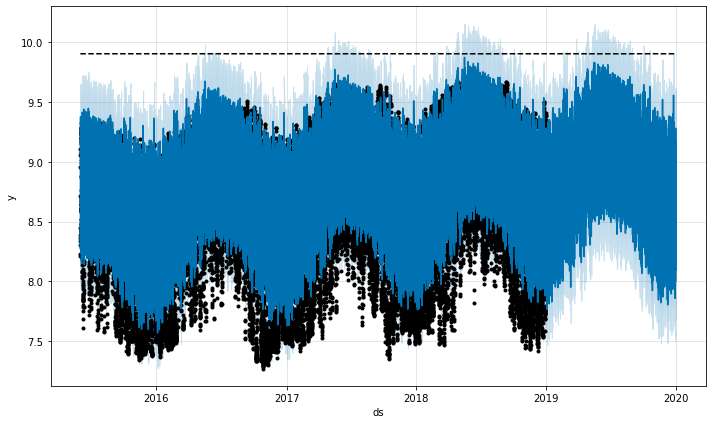

In [6]:
model.plot(forcast)
forcast.head()


Plot the seasonal and added regressor components of the time series model.  Seems similar to SARIMA model, however does not function in the same manner.  FB seems to have a form of gradient decent based off the messages given in terminal when training.

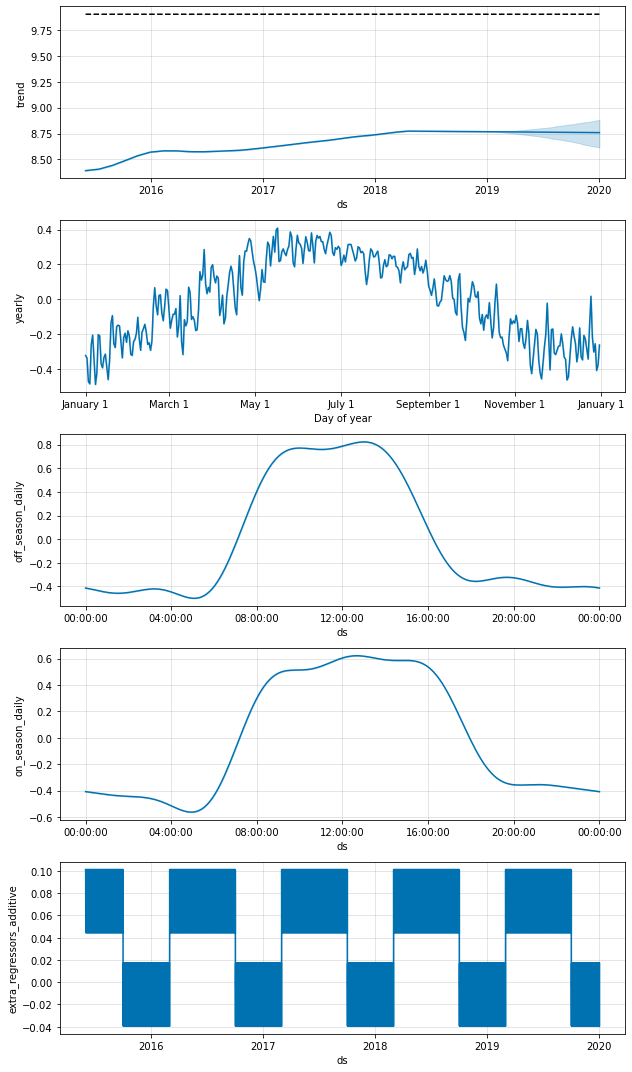

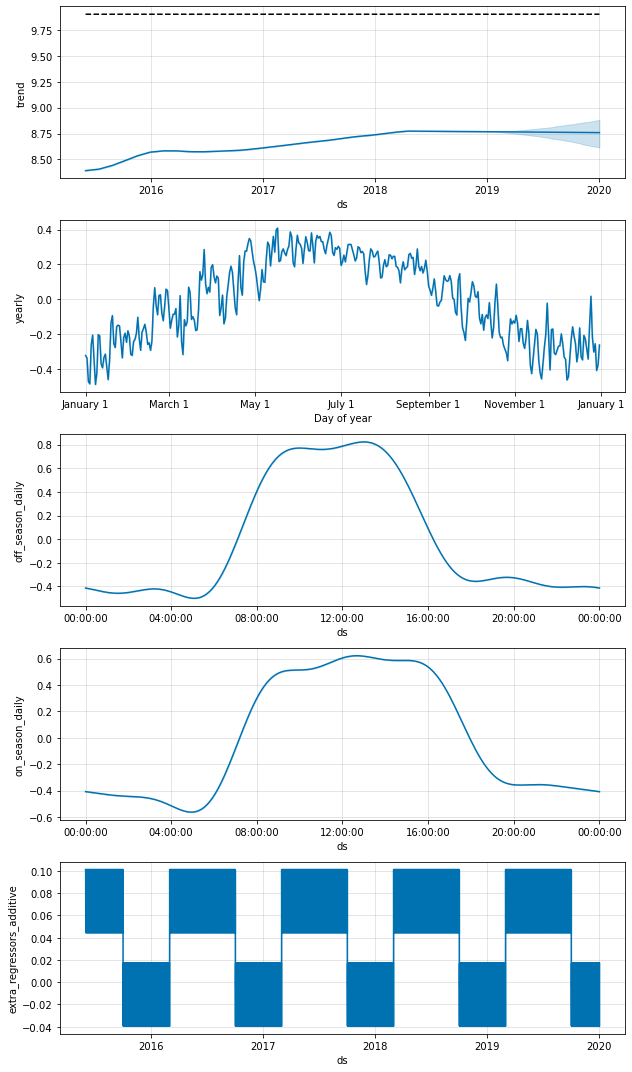

In [7]:
model.plot_components(forcast)

In [9]:
dd['y'] = np.exp(dd['y'])
#dd['y'] = (dd['y'])**3
dd_train['y'] = np.exp(dd_train['y'])
#dd_train['y'] = (dd_train['y'])**3
forcast['yhat'] = np.exp(forcast['yhat'])
#forcast['yhat'] = (forcast['yhat'])**3
dd_test = dd.loc[dd['ds']>pd.to_datetime('01/01/2019')]

Visualize predictions on training and test years.  Line is too crazy with this many data points per day, dots are a little easier to see.  Visual can certainly be deceptive.

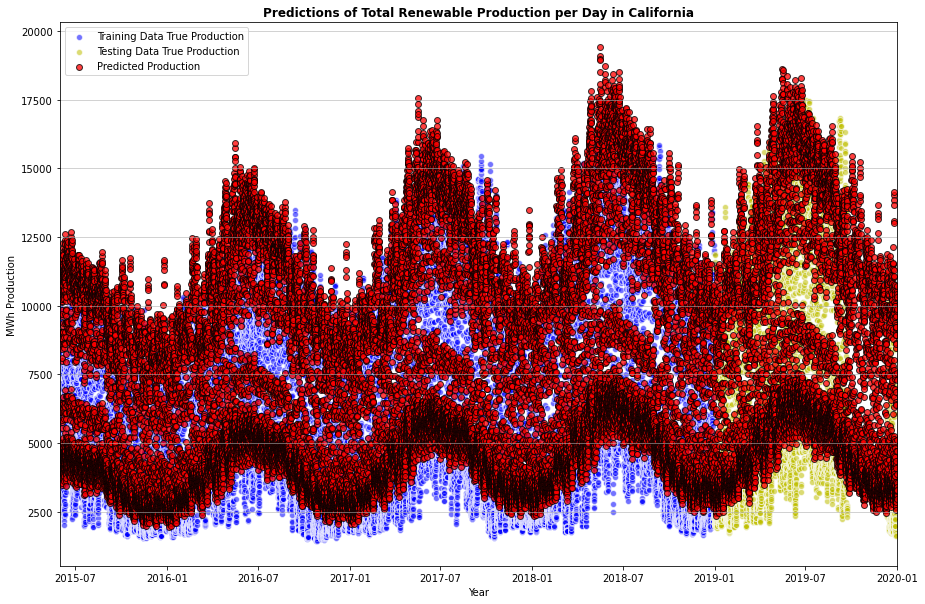

In [10]:

plt.figure(figsize=(15,10))

plt.scatter(dd_train['ds'],dd_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_test['ds'],dd_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('01/01/2020'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Renewable Production per Day in California",fontweight='bold')
plt.show()

Visualize prediction accuracy and provide some accuracy metrics on the training and testing data.  Sum the production per day rather than plotting hourly values here to make it easier to absorb

Predicted Total Renewable Production 2019:  53262.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  4976.0


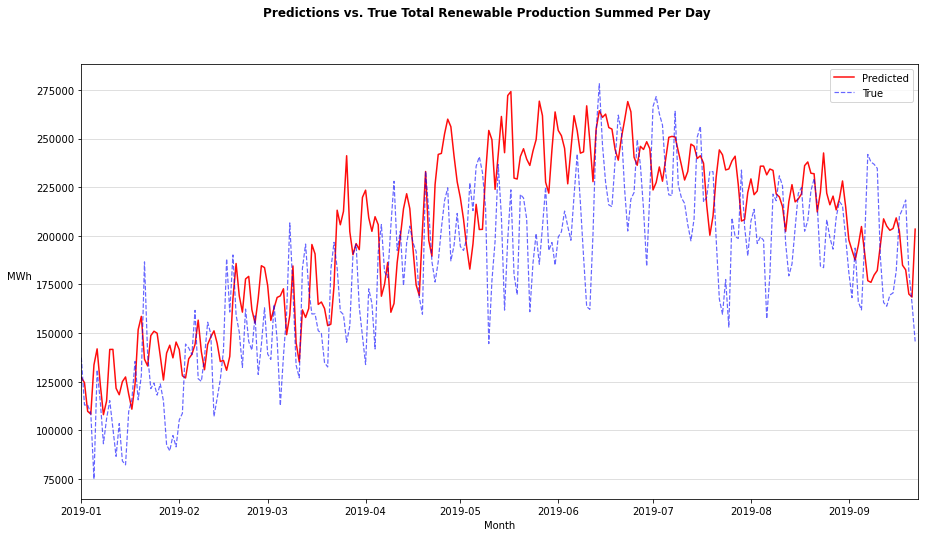

Train MAPE:  24.69490194718081
Train R2:  0.791767028228931
Test MAPE:  25.01531798155807
Test R2:  0.7881159216300685


In [11]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                            (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])
#test data predictions and true values
tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),
                  how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)

#for plotting
dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'yhat'].values


#for plotting
datat = dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('24H').sum().loc[:,'y'].values


month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))

plt.show()

#for calculations, training data
yhat_train = pd.DataFrame(forcast.loc[(forcast['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_train = pd.DataFrame(dd.loc[(dd['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])
#combine above two into one for calculations on training data 
tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', mape)
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values
yhat_test = tester['yhat'].values
mape2 = (np.sum(np.nan_to_num(np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/true)),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


### Building Model for Solar Production per hour.

I redefine most of the functions here to make them fit for solar power specifically.  Not the best way to go about it, havent came back through code yet to refactor to have it be more easily maintained or have it be able to be incorporated into a ML pipeline.

Comments will be more sparse here as its a lot of repeated code but for solar rather than all renewbale sources combined.

In [12]:
full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['SOLAR TOTAL']
#daily_renew = y.resample('4H').sum()
daily_renew = y
dd_s = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month > 3) & (date.month < 11)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month > 3) & (date.month < 11))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 10:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1



dd_s.columns = ['ds','y']

scaler = StandardScaler()

dd_s['cap'] = np.cbrt(15000)
dd_s['floor'] = 0
#dd_s['cap'] = np.log(dd['cap'])

dd_s['on_season'] = dd_s['ds'].apply(on_season)
dd_s['off_season'] = ~dd_s['ds'].apply(on_season)
dd_s['daytime'] = dd_s['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd_s['on_seasonr'] = dd_s['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
#dd['y'] = dd['y'].replace(0,dd['y'].median())
dd_s['y'] = np.cbrt(dd_s['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
#dd_s['y'] = np.log(dd_s['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_season'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd_s['daytime'].values
daytimev = daytimev.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd_s['daytime'] = scaler.fit_transform(daytimev)

dd_s_train = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2016'))&(dd_s['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_s_train.head(8))

dd_s_train.info()

ds         y        cap  floor  on_season  off_season  \
5136 2016-01-01 00:00:00  0.000000  24.662121      0      False        True   
5137 2016-01-01 01:00:00  0.000000  24.662121      0      False        True   
5138 2016-01-01 02:00:00  0.000000  24.662121      0      False        True   
5139 2016-01-01 03:00:00  0.000000  24.662121      0      False        True   
5140 2016-01-01 04:00:00  0.000000  24.662121      0      False        True   
5141 2016-01-01 05:00:00  0.000000  24.662121      0      False        True   
5142 2016-01-01 06:00:00  0.000000  24.662121      0      False        True   
5143 2016-01-01 07:00:00  9.020529  24.662121      0      False        True   

       daytime  on_seasonr  
5136 -0.816497           0  
5137 -0.816497           0  
5138 -0.816497           0  
5139 -0.816497           0  
5140 -0.816497           0  
5141 -0.816497           0  
5142 -0.816497           0  
5143 -0.816497           0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26256 entries, 5136 to 31391
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          26256 non-null  datetime64[ns]
 1   y           26256 non-null  float64       
 2   cap         26256 non-null  float64       
 3   floor       26256 non-null  int64         
 4   on_season   26256 non-null  bool          
 5   off_season  26256 non-null  bool          
 6   daytime     26256 non-null  float64       
 7   on_seasonr  26256 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(3), int64(2)
memory usage: 1.5 MB


In [13]:
model = Prophet(changepoint_range=.8,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.01,seasonality_prior_scale=20)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=10,prior_scale=1)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=10,prior_scale=1)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
#model.add_regressor('daytime',standardize=False)
#model.add_regressor('equinox')
#model.add_regressor('on_seasonr',standardize=False)
#model.add_regressor('year')
model.fit(dd_s_train)



In [14]:
futures = model.make_future_dataframe(periods=365*24,freq='1H')
futures['on_season'] = futures['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
futures['off_season'] = ~futures['ds'].apply(on_season)
futures['daytime'] = futures['ds'].apply(daytime)
futures['on_seasonr'] = futures['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
futures['cap'] = np.cbrt(15000)
futures['floor'] = 0
#futures['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = futures['daytime'].values
daytimef = daytimef.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
futures['daytime'] = scaler.fit_transform(daytimef)

forcasts = model.predict(futures)

ds     trend        cap  floor  yhat_lower  yhat_upper  \
35011 2019-12-31 19:00:00  9.191854  24.662121      0   -2.601838    1.893825   
35012 2019-12-31 20:00:00  9.191871  24.662121      0   -3.048258    1.654386   
35013 2019-12-31 21:00:00  9.191888  24.662121      0   -2.867015    1.775079   
35014 2019-12-31 22:00:00  9.191905  24.662121      0   -3.111986    1.449902   
35015 2019-12-31 23:00:00  9.191922  24.662121      0   -2.951562    1.602174   

       trend_lower  trend_upper  additive_terms  additive_terms_lower  ...  \
35011     9.049686     9.340915       -9.540346             -9.540346  ...   
35012     9.049679     9.340965       -9.946625             -9.946625  ...   
35013     9.049672     9.341015       -9.726344             -9.726344  ...   
35014     9.049665     9.341065       -9.984004             -9.984004  ...   
35015     9.049658     9.341115       -9.850410             -9.850410  ...   

       on_season_daily  on_season_daily_lower  on_season_daily_upper  \
35011              0.0                    0.0                    0.0   
35012              0.0                    0.0                    0.0   
35013              0.0                    0.0                    0.0   
35014              0.0                    0.0                    0.0   
35015              0.0                    0.0                    0.0   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
35011 -3.018749     -3.018749     -3.018749                   0.0   
35012 -3.008098     -3.008098     -3.008098                   0.0   
35013 -2.993293     -2.993293     -2.993293                   0.0   
35014 -2.974542     -2.974542     -2.974542                   0.0   
35015 -2.952087     -2.952087     -2.952087                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper      yhat  
35011                         0.0                         0.0 -0.348492  
35012                         0.0                         0.0 -0.754754  
35013                         0.0                         0.0 -0.534456  
35014                         0.0                         0.0 -0.792099  
35015                         0.0                         0.0 -0.658488  

[5 rows x 24 columns]

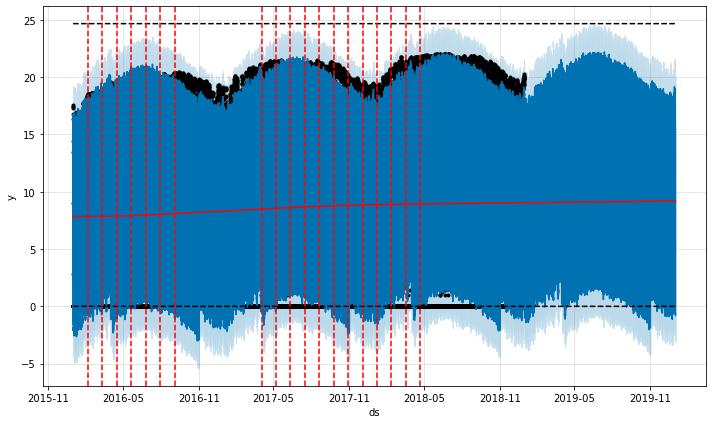

In [15]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forcasts)
a = add_changepoints_to_plot(fig.gca(), model, forcasts)
forcasts.tail()

Solar has a much more consistant over time trend.  Solar seems to be very predictable based off time alone.  

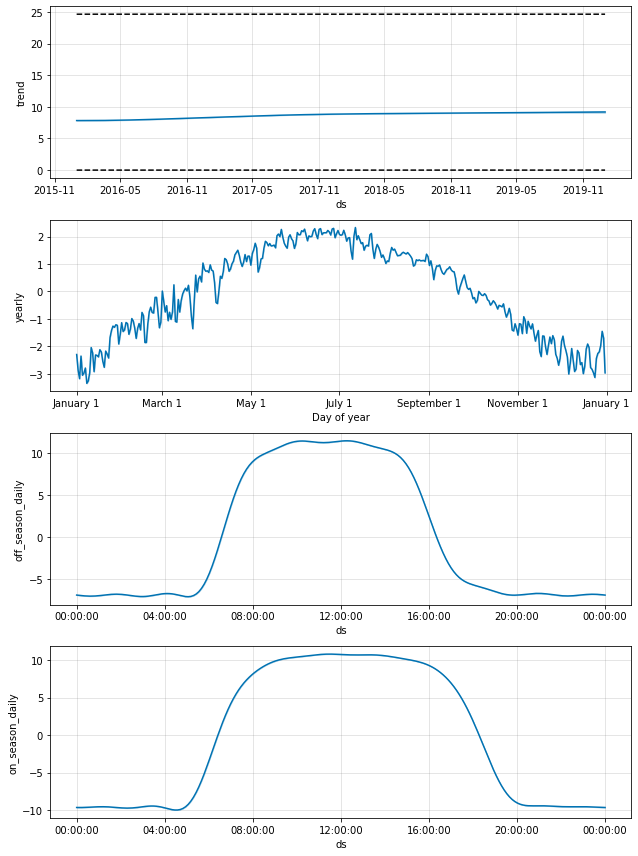

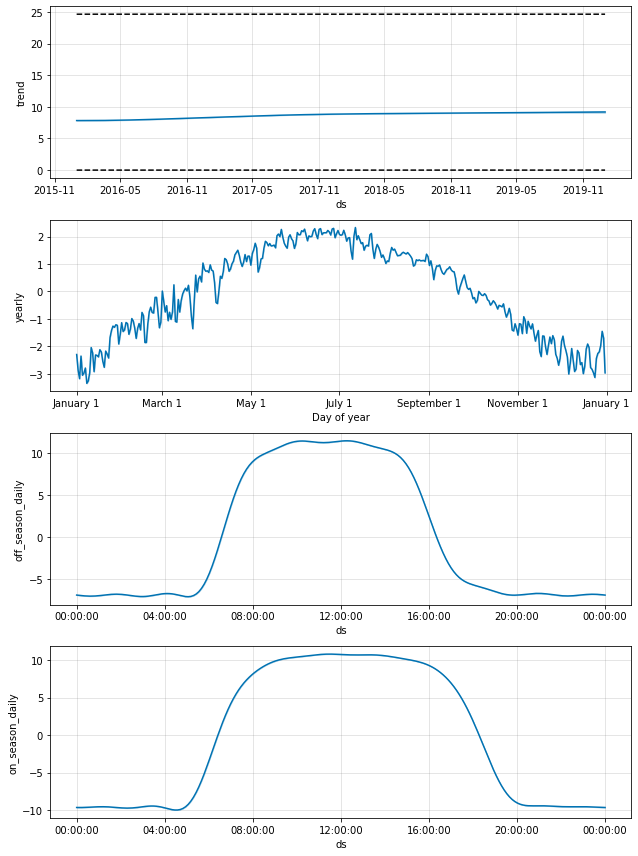

In [16]:
model.plot_components(forcasts)

In [17]:
#dd_s['y'] = np.exp(dd['y'])
dd_s['y'] = (dd_s['y'])**3
#dd_s_train['y'] = np.exp(dd_s_train['y'])
dd_s_train['y'] = (dd_s_train['y'])**3
#forcasts['yhst'] = np.exp(forcast['yhat'])
forcasts['yhat'] = (forcasts['yhat'])**3
dd_s_test = dd_s.loc[dd_s['ds']>pd.to_datetime('01/01/2019')]

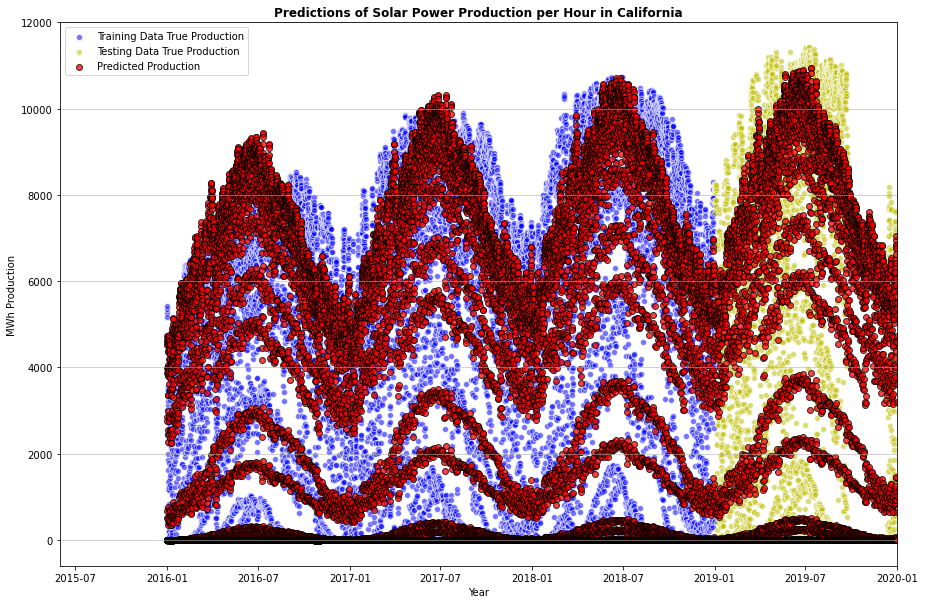

In [18]:

plt.figure(figsize=(15,10))

plt.scatter(dd_s_train['ds'],dd_s_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_s_test['ds'],dd_s_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcasts['ds'],forcasts['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('01/01/2020'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Solar Power Production per Hour in California",fontweight='bold')
plt.show()

Solar shows to be very predictable, and therefore a reliable source of renewable energy.  This predictablilty may be a factor in why it has grown exponentially in comparison to all other renewable sources in the last decade.  (Here Comes The Sun repository provides an in depth analysis of renewable production).  

Predicted total solar Production 2017:  20558.0
True total solar Production 2017:  22684.0
Error in year total prediction in GWh:  -2126.0


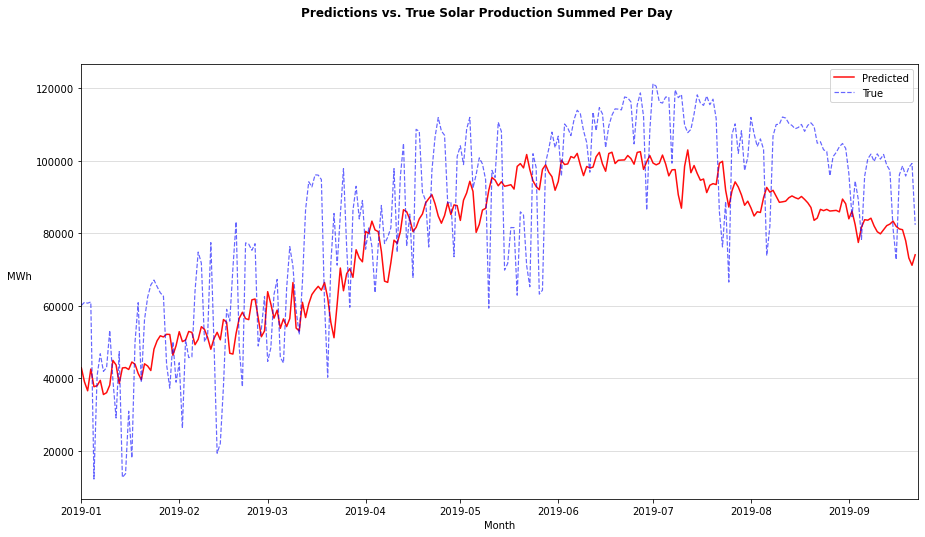

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars


Test MAPE:  inf
Train R2:  0.9380021016542865
Test MAPE:  inf
Test R2:  0.9125458497017771


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


In [19]:
yhats = pd.DataFrame(forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                                   (forcasts['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
trues = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (dd_s['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

testers = pd.merge(yhats.set_index(pd.DatetimeIndex(yhats['ds'])),(trues.set_index(pd.DatetimeIndex(trues['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted total solar Production 2017: ',(testers['yhat'].sum())//1000)
print('True total solar Production 2017: ',testers['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (testers['yhat'].sum()-testers['y'].sum())//1000)


datafs = forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                       (forcasts['ds'] < pd.to_datetime('09/23/2019'))),:].\
set_index(pd.DatetimeIndex(forcasts.loc[((forcasts['ds'] >= pd.to_datetime\
                                          ('01/01/2019')) & (forcasts['ds'] \
                                                             < pd.to_datetime\
                                                             ('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'yhat'].values



datats = dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                   (dd_s['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                            (dd_s['ds'] < pd.to_datetime('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'y'].values

month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,datafs,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datats,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Solar Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
#plt.ylim(bottom=75000,top=260000)
plt.show()

yhat_trains = pd.DataFrame(forcasts.loc[\
                                         (forcasts['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_trains = pd.DataFrame(dd_s.loc[\
                                     (dd_s['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])

tester_trains = pd.merge(yhat_trains.set_index(pd.DatetimeIndex(yhat_trains['ds'])),(true_trains.set_index(pd.DatetimeIndex(true_trains['ds']))),how='left',left_index=True,right_index=True)


tester_trains['msem'] = ((tester_trains['y']-tester_trains['yhat'])**2)
tester_trains['mseb'] = (tester_trains['y']-tester_trains['y'].mean())**2
r2 = 1 - ((np.sum(tester_trains['msem'])/len(tester_trains))/(np.sum(tester_trains['mseb'])/len(tester_trains)))
true_trains = tester_trains['y'].values
yhat_trains = tester_trains['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/np.nan_to_num(true))),true_trains,yhat_trains)))*(100/len(true_trains))
print('Test MAPE: ', mape)
print('Train R2: ',r2)


testers['msem'] = ((testers['y']-testers['yhat'])**2)
testers['mseb'] = (testers['y']-testers['y'].mean())**2
r2 = 1 - ((np.sum(testers['msem'])/len(testers))/(np.sum(testers['mseb'])/len(testers)))
true_tests = testers['y'].values
yhat_tests = testers['yhat'].values
mape2 = (np.sum((np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/(true))),true_tests,yhat_tests)))))*100)/len(true_tests)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


##### Since solar provides most of the renewable power, and because it's prediction accuracy was so good, wanted to try and add in predictions from solar model as an extra regressor in total renewable production model.

Currently have it turend off for the last training/ fitting run I did.  Using this as a testing case and trying to learn about some of the parameters a little more here.  Part of the "In Progress" part.

Extra features are automatically normalized by default.  It isn't entirely clear how they standardize so I wanted to test with sklearn standard scaler.  Need to refactor the way the data is scaled because scale both the training and testing together.  This allows for some of the information from the testing year to be included in the way the training data is scaled, and therefore can slightly "cheat" your model and provide slightly inflated accuracy metrics.

In [46]:
 
full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['TOTAL']

daily_renew = y
dd = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month >= 4) & (date.month <= 9)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3) & (date.month < 11))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1
def get_year(ds):
    date = pd.to_datetime(ds)
    if date.year <= 2014:
        return -2
    elif date.year <= 2015:
        return -1
    elif date.year <= 2016:
        return 0
    elif date.year <= 2017:
        return 1
    elif date.year <= 2018:
        return 2


dd.columns = ['ds','y']

dd_sm = forcasts.loc[:,['ds','yhat']]
print('''forcasts.loc[:,['ds','yhat']].head()''')
display(forcasts.loc[:,['ds','yhat']].head())

dd = pd.merge(dd.set_index(pd.DatetimeIndex(dd['ds'])),(dd_sm.set_index(pd.DatetimeIndex(dd_sm['ds']))),
              how='left',left_index=True,right_index=True)
dd = dd.reset_index()
dd.drop(columns=['ds_x','ds_y'],inplace=True)
dd.columns = ['ds','y','solar']
display(dd.head())


scaler = StandardScaler()

dd['cap'] = 25000
dd['cap'] = np.log(dd['cap'])

dd['on_season'] = dd['ds'].apply(on_season)
dd['off_season'] = ~dd['ds'].apply(on_season)
dd['daytime'] = dd['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd['on_seasonr'] = dd['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
dd['y'] = dd['y'].replace(0,dd['y'].median())
#dd['y'] = np.cbrt(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
dd['y'] = np.log(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_seasonr'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd['daytime'].values
daytimev = daytimev.reshape(-1,1)

solarv = dd['solar'].values
solarv = solarv.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd['daytime'] = scaler.fit_transform(daytimev)
dd['solar'] = scaler.fit_transform(solarv)

dd_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2016'))&(dd['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_train.head(8))

dd_train.info()

forcasts.loc[:,['ds','yhat']].head()


ds      yhat
0 2016-01-01 00:00:00 -8.844595
1 2016-01-01 01:00:00 -9.451883
2 2016-01-01 02:00:00 -7.031421
3 2016-01-01 03:00:00 -9.868032
4 2016-01-01 04:00:00 -5.453305

ds     y  solar
0 2015-06-01 00:00:00  4669    NaN
1 2015-06-01 01:00:00  4396    NaN
2 2015-06-01 02:00:00  4197    NaN
3 2015-06-01 03:00:00  4059    NaN
4 2015-06-01 04:00:00  3694    NaN

ds         y     solar        cap  on_season  \
5136 2016-01-01 00:00:00  7.942007 -0.808571  10.126631      False   
5137 2016-01-01 01:00:00  7.929487 -0.808746  10.126631      False   
5138 2016-01-01 02:00:00  7.909122 -0.808050  10.126631      False   
5139 2016-01-01 03:00:00  7.920083 -0.808866  10.126631      False   
5140 2016-01-01 04:00:00  7.945910 -0.807596  10.126631      False   
5141 2016-01-01 05:00:00  7.919720 -0.808635  10.126631      False   
5142 2016-01-01 06:00:00  7.916807 -0.805974  10.126631      False   
5143 2016-01-01 07:00:00  8.101072 -0.612553  10.126631      False   

      off_season   daytime  on_seasonr  
5136        True -0.795932           0  
5137        True -0.795932           0  
5138        True -0.795932           0  
5139        True -0.795932           0  
5140        True -0.795932           0  
5141        True -0.795932           0  
5142        True -0.795932           0  
5143        True -0.795932           0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26256 entries, 5136 to 31391
Data columns (total 8 columns):
ds            26256 non-null datetime64[ns]
y             26256 non-null float64
solar         26256 non-null float64
cap           26256 non-null float64
on_season     26256 non-null bool
off_season    26256 non-null bool
daytime       26256 non-null float64
on_seasonr    26256 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(4), int64(1)
memory usage: 1.5 MB


In [20]:
model = Prophet(changepoint_range=.45,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.001,seasonality_prior_scale=20)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=3,prior_scale=.01)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=3,prior_scale=.01)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime',standardize=False)
model.add_regressor('solar',standardize=True)
model.add_regressor('on_seasonr',standardize=False)
#model.add_regressor('year')
model.fit(dd_train)



In [21]:
future = model.make_future_dataframe(periods=365*24,freq='1H')

dd_smf = forcasts.loc[:,['ds','yhat']]

future = pd.merge(future.set_index(pd.DatetimeIndex(future['ds'])),(dd_smf.set_index(pd.DatetimeIndex(dd_smf['ds']))),how='left',left_index=True,right_index=True)
future = future.reset_index()
future.drop(columns=['ds_x','ds_y'],inplace=True)

future.info()
future.loc[(future['ds'] > pd.to_datetime('09/23/2019'))&(future['ds']< pd.to_datetime('12/16/2019'))].tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35016 entries, 0 to 35015
Data columns (total 2 columns):
ds      35016 non-null datetime64[ns]
yhat    35016 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 547.2 KB


ds          yhat
34627 2019-12-15 19:00:00  4.332209e-07
34628 2019-12-15 20:00:00 -7.752070e-02
34629 2019-12-15 21:00:00 -1.366061e-02
34630 2019-12-15 22:00:00 -1.526904e-01
34631 2019-12-15 23:00:00 -8.704911e-02

In [22]:
future.rename(columns={
    'yhat':'solar'
}, inplace=True)
future['on_season'] = future['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
future['off_season'] = ~future['ds'].apply(on_season)
future['daytime'] = future['ds'].apply(daytime)
future['on_seasonr'] = future['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
future['cap'] = 25000
future['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = future['daytime'].values
daytimef = daytimef.reshape(-1,1)

solarf = future['solar'].values
solarf = solarf.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
future['daytime'] = scaler.fit_transform(daytimef)
future['solar'] = scaler.fit_transform(solarf)

display(future.head())


ds     solar  on_season  off_season   daytime  on_seasonr  \
0 2016-01-01 00:00:00 -0.807722      False        True -0.795932           0   
1 2016-01-01 01:00:00 -0.807898      False        True -0.795932           0   
2 2016-01-01 02:00:00 -0.807197      False        True -0.795932           0   
3 2016-01-01 03:00:00 -0.808019      False        True -0.795932           0   
4 2016-01-01 04:00:00 -0.806739      False        True -0.795932           0   

         cap  
0  10.126631  
1  10.126631  
2  10.126631  
3  10.126631  
4  10.126631

In [23]:
forcast = model.predict(future)

ds     trend        cap  yhat_lower  yhat_upper  \
35011 2019-12-31 19:00:00  8.718019  10.126631    7.825120    8.454735   
35012 2019-12-31 20:00:00  8.718029  10.126631    7.801234    8.405717   
35013 2019-12-31 21:00:00  8.718039  10.126631    7.822851    8.411454   
35014 2019-12-31 22:00:00  8.718049  10.126631    7.846338    8.412579   
35015 2019-12-31 23:00:00  8.718060  10.126631    7.840581    8.446038   

       trend_lower  trend_upper  additive_terms  additive_terms_lower  \
35011     8.712460     8.724117       -0.583992             -0.583992   
35012     8.712469     8.724129       -0.634531             -0.634531   
35013     8.712478     8.724141       -0.608303             -0.608303   
35014     8.712487     8.724152       -0.584608             -0.584608   
35015     8.712496     8.724164       -0.579695             -0.579695   

       additive_terms_upper  ...  on_seasonr  on_seasonr_lower  \
35011             -0.583992  ...         0.0               0.0   
35012             -0.634531  ...         0.0               0.0   
35013             -0.608303  ...         0.0               0.0   
35014             -0.584608  ...         0.0               0.0   
35015             -0.579695  ...         0.0               0.0   

       on_seasonr_upper    yearly  yearly_lower  yearly_upper  \
35011               0.0 -0.229503     -0.229503     -0.229503   
35012               0.0 -0.230626     -0.230626     -0.230626   
35013               0.0 -0.231833     -0.231833     -0.231833   
35014               0.0 -0.233100     -0.233100     -0.233100   
35015               0.0 -0.234402     -0.234402     -0.234402   

       multiplicative_terms  multiplicative_terms_lower  \
35011                   0.0                         0.0   
35012                   0.0                         0.0   
35013                   0.0                         0.0   
35014                   0.0                         0.0   
35015                   0.0                         0.0   

       multiplicative_terms_upper      yhat  
35011                         0.0  8.134027  
35012                         0.0  8.083498  
35013                         0.0  8.109737  
35014                         0.0  8.133441  
35015                         0.0  8.138365  

[5 rows x 32 columns]

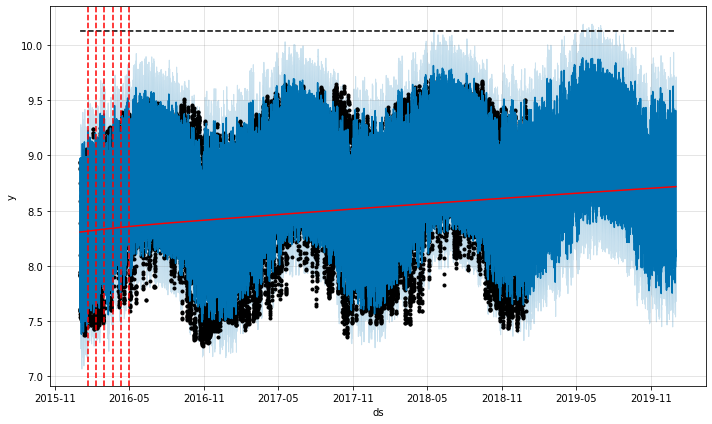

In [24]:
fig = model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(), model, forcast)
forcast.tail()

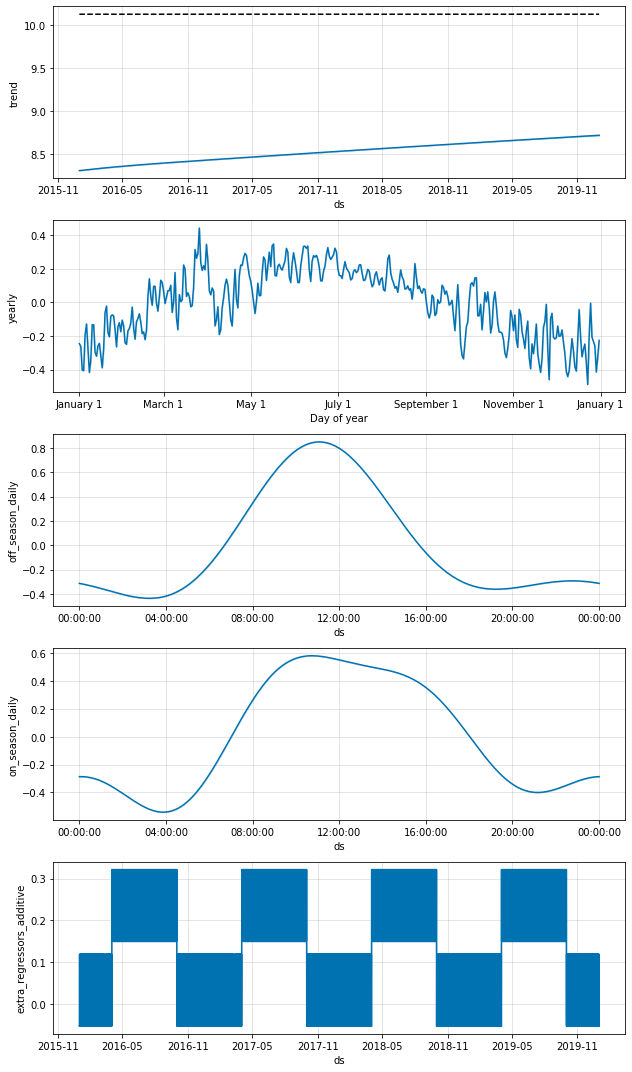

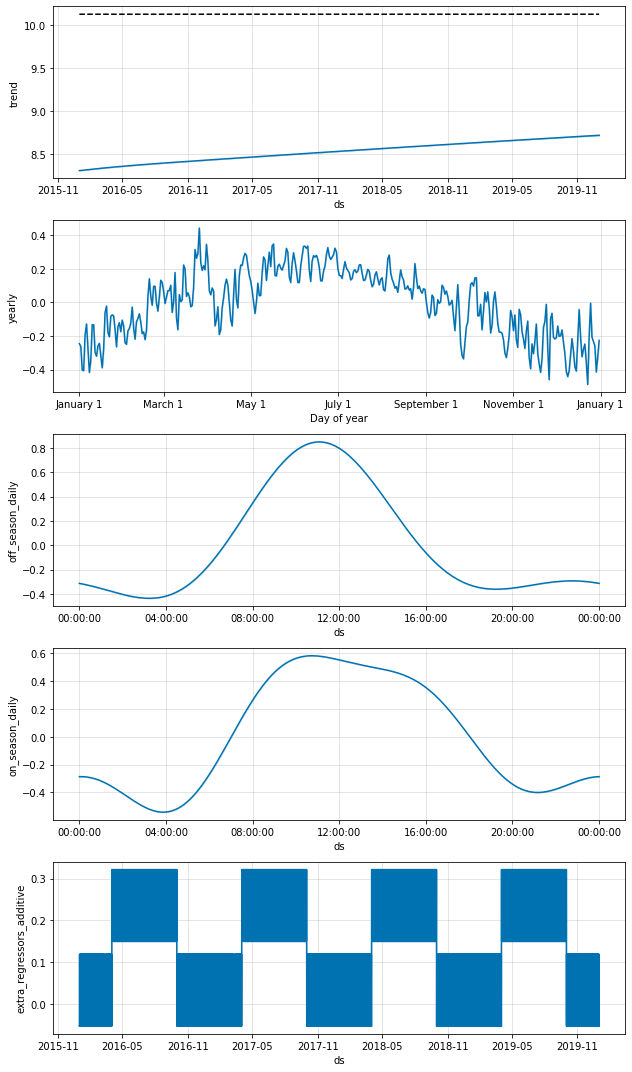

In [25]:
model.plot_components(forcast)

In [26]:
dd['y'] = np.exp(dd['y'])
#dd['y'] = (dd['y'])**3
dd_train['y'] = np.exp(dd_train['y'])
#dd_train['y'] = (dd_train['y'])**3
forcast['yhat'] = np.exp(forcast['yhat'])
#forcast['yhat'] = (forcast['yhat'])**3
dd_test = dd.loc[dd['ds']>pd.to_datetime('01/01/2019')]

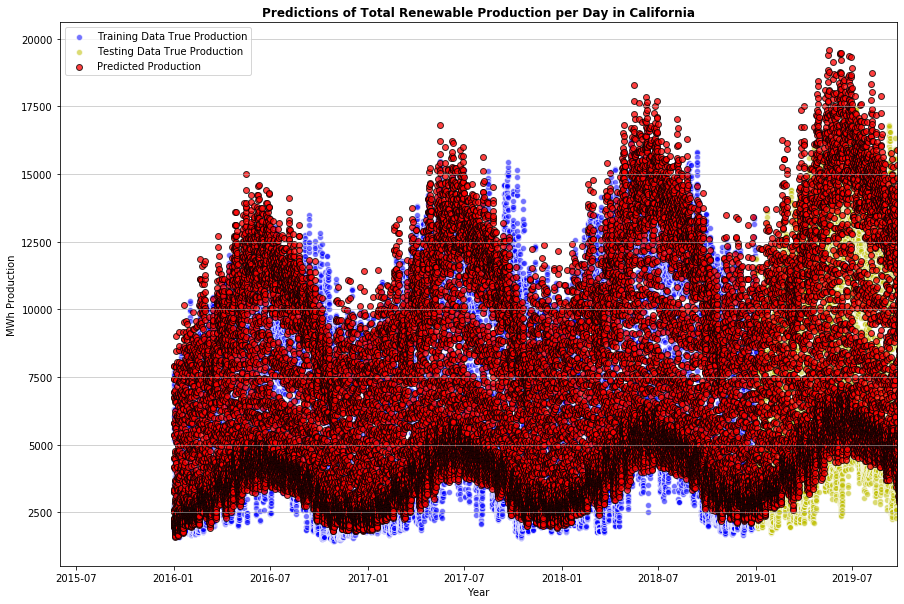

In [27]:

plt.figure(figsize=(15,10))

plt.scatter(dd_train['ds'],dd_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_test['ds'],dd_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('09/23/2019'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Renewable Production per Day in California",fontweight='bold')
plt.show()

Predicted Total Renewable Production 2019:  51545.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  3258.0


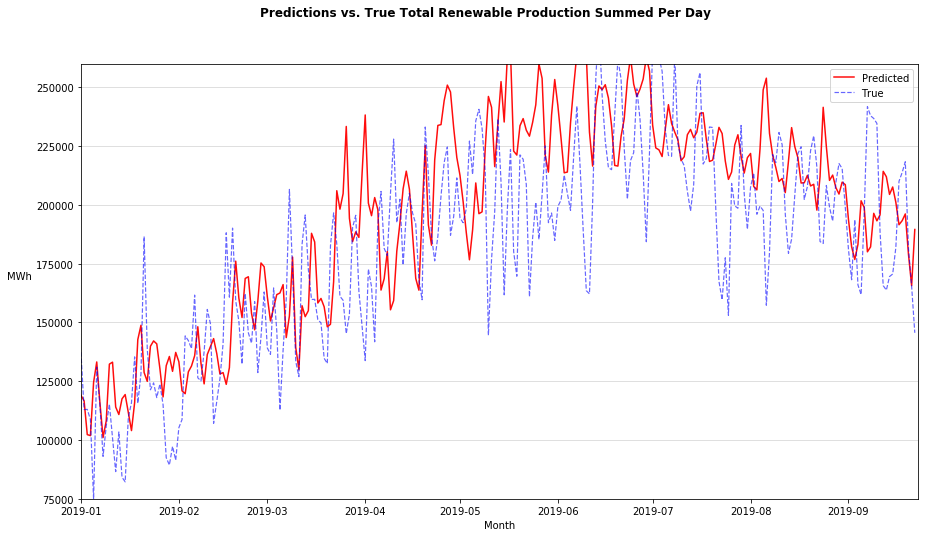

Train MAPE:  19.15697753571003
Train R2:  0.8620782172941612
Test MAPE:  23.484768977670228
Test R2:  0.7895219100026772


In [28]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)


dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('24H').sum().loc[:,'yhat'].values


datat = dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).resample('24H').sum().loc[:,'y'].values



month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
plt.ylim(bottom=75000,top=260000)
plt.show()

yhat_train = pd.DataFrame(forcast.loc[\
                                       (forcast['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_train = pd.DataFrame(dd.loc[\
                                  (dd['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])

tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', mape)
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values
yhat_test = tester['yhat'].values
mape2 = (np.sum((np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/np.nan_to_num(true))),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [29]:
forcast['solar'] = forcasts['yhat']
predictions = forcast.loc[:,['ds','solar','yhat']]
predictions.rename(columns={
    'ds':'timestamp',
    'solar':'Pred Solar Prod',
    'yhat':'Pred Tot Renew Prod'
}, inplace=True)
predictions['Hour'] = predictions['timestamp'].dt.hour
predictions = predictions[['timestamp','Hour','Pred Tot Renew Prod','Pred Solar Prod']]
predictions.head(24)

timestamp  Hour  Pred Tot Renew Prod  Pred Solar Prod
0  2016-01-01 00:00:00     0          2221.704348        -8.844595
1  2016-01-01 01:00:00     1          2127.548858        -9.451883
2  2016-01-01 02:00:00     2          2023.691710        -7.031421
3  2016-01-01 03:00:00     3          1960.549607        -9.868032
4  2016-01-01 04:00:00     4          1991.603628        -5.453305
5  2016-01-01 05:00:00     5          2173.137197        -9.065528
6  2016-01-01 06:00:00     6          2570.631469         0.183324
7  2016-01-01 07:00:00     7          3254.804998       672.466490
8  2016-01-01 08:00:00     8          4508.130710      2835.440671
9  2016-01-01 09:00:00     9          5790.891252      3846.053762
10 2016-01-01 10:00:00    10          6931.354909      4606.222397
11 2016-01-01 11:00:00    11          7437.013442      4529.409050
12 2016-01-01 12:00:00    12          7913.066477      4696.835925
13 2016-01-01 13:00:00    13          6745.936034      4501.870638
14 2016-01-01 14:00:00    14          5368.926783      3969.161082
15 2016-01-01 15:00:00    15          4190.187518      2736.482587
16 2016-01-01 16:00:00    16          3356.344629       500.079800
17 2016-01-01 17:00:00    17          2538.289811         6.057879
18 2016-01-01 18:00:00    18          2304.290653        -0.007548
19 2016-01-01 19:00:00    19          2225.177038        -0.952253
20 2016-01-01 20:00:00    20          2118.957823        -2.650103
21 2016-01-01 21:00:00    21          2179.064050        -1.583512
22 2016-01-01 22:00:00    22          2235.368799        -2.944965
23 2016-01-01 23:00:00    23          2250.529071        -2.289538

### Write predictions to database.  Commented out because I don't want to write and re-write to the database while making changes and edits to the notebook.

In [30]:
# name = 'hourlyrenewablepredictions'
# schema = 'Predictions'

# with engine.connect() as c:
#     c.execute('''CREATE SCHEMA "Predictions"''')

# predictions.to_sql(name=name, con=con, schema=schema, if_exists='replace',index=False)

In [31]:
# with engine.connect() as c:
#     c.execute('''ALTER TABLE "Predictions".hourlyrenewablepredictions 
#     ADD PRIMARY KEY ("timestamp")''')

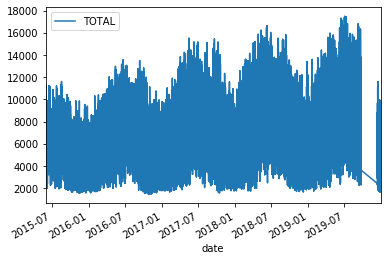

In [32]:
full_data.plot(x='date',
              y='TOTAL')

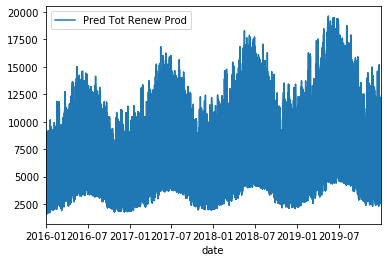

In [33]:
predictions['date'] = pd.to_datetime(predictions['timestamp']).dt.date
predictions.plot(x='date',
              y='Pred Tot Renew Prod')

Doing some more visualization of how well the model predicts. Trying a few ways to see what I think could be best to explain the model to non-data people.

In [34]:
from sklearn.metrics import mean_absolute_error as MAE
#train Mean Absolute Error 
MAE(tester_train['y'], tester_train['yhat'])

1006.3656495451198

In [35]:
#test mae
MAE(tester['y'], tester['yhat'])

1431.0636388487264

Predicted Total Renewable Production 2019:  51545.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  3258.0


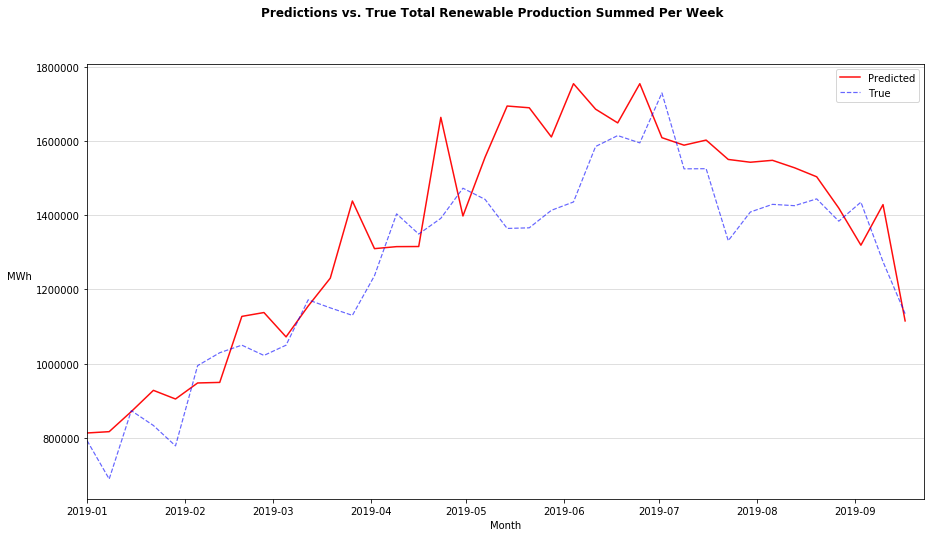

In [36]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)


dataf = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('7D').sum().loc[:,'yhat'])


datat = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).resample('7D').sum().loc[:,'y'])



month_list = pd.date_range('01/01/2019','09/23/2019',freq='1M')


plt.figure(figsize=(15,8))
plt.plot(dataf.index,dataf.reset_index()['yhat'],label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(datat.index,datat.reset_index()['y'],label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Week',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
# plt.ylim(bottom=75000,top=260000)
plt.show()




(50000, 278485.60428302974)

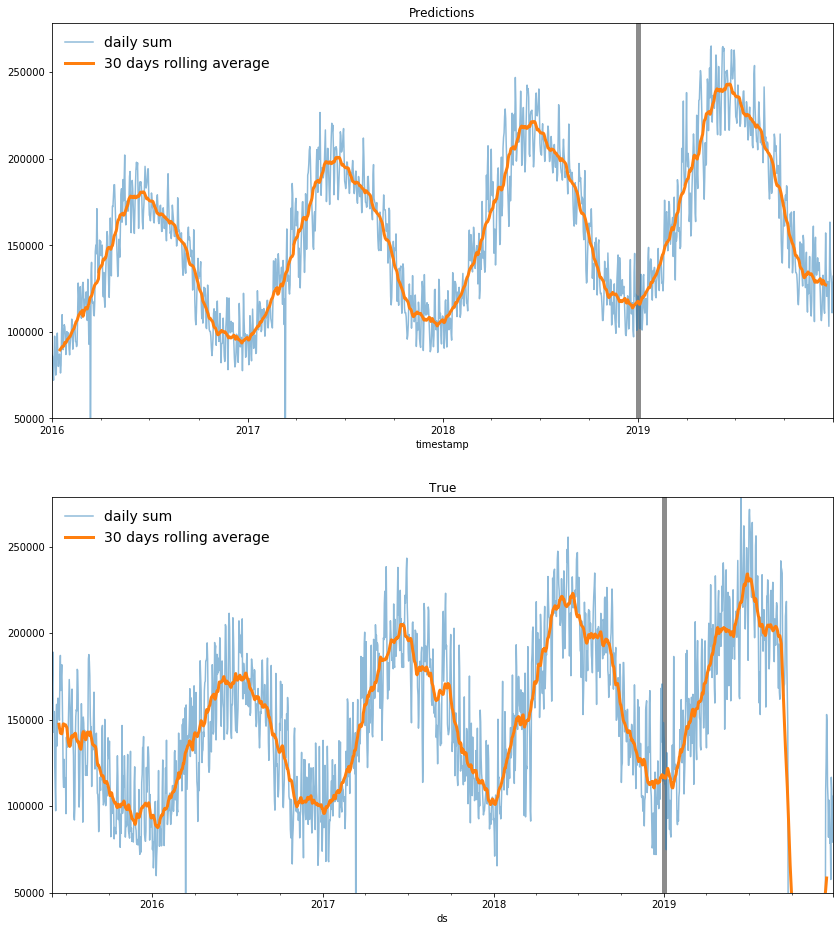

In [37]:
data = pd.DataFrame(predictions['Pred Tot Renew Prod']).set_index(pd.DatetimeIndex(predictions['timestamp'])).resample('1D').sum()
pd.plotting.register_matplotlib_converters()
f, axes = plt.subplots(nrows=2, figsize=(14,16), sharey=True)

ax = axes[0]

data.plot(ax=ax, alpha=0.5, title="Predictions")
data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3)
ax.legend(['daily sum','30 days rolling average'], frameon=False, fontsize=14)
ax.axvline(pd.to_datetime('2019-01-01'),lw=5,color='k',alpha=.45,zorder=-1)
ax.set_ylim(bottom=50000)

ax = axes[1]

data = pd.DataFrame(dd['y']).set_index(pd.DatetimeIndex(dd['ds'])).resample('1D').sum()
data.plot(ax=ax, alpha=0.5, title="True")
data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3)
ax.legend(['daily sum','30 days rolling average'], frameon=False, fontsize=14)
ax.axvline(pd.to_datetime('2019-01-01'),lw=5,color='k',alpha=.45,zorder=-1)
ax.set_ylim(bottom=50000)


Text(-12000, 20000, 'R2: 0.79')

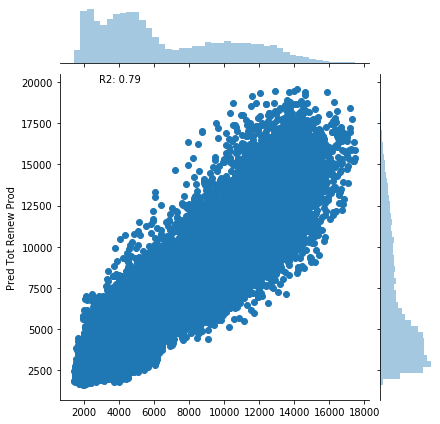

In [38]:
sns.jointplot(x=full_data.loc[((full_data['date'] >= pd.to_datetime('01/01/2016'))&\
                               (full_data['date'] < pd.to_datetime('09/23/2019'))),'TOTAL']\
              .values,y=predictions.loc[predictions['timestamp'] < pd.to_datetime('09/23/2019'),
                                                                                         'Pred Tot Renew Prod'])


plt.text(-12000,20000,s='R2: {}'.format(round(r2,3)))

# Now Building Demand Predictions

Same process as above, just different data with very differnt trend.  Consumption based on human use, humans seem more predictable than nature.  At least with energy consumption.

Still perfecting this model.  Need to look into weekend differences, on off season definition.  Name is ambiguous but there are two differnt daily trends observable in the demand.  Some days have one peak, some have two with the evening always being larger.  That is the separation of on/off season daily trend.

In [20]:
sql_demand = '''SELECT * FROM "Demand".hourlydemand;'''

demand_df = pd.read_sql(sql=sql_demand, con=con)
demand_df.head()

timestamp        date  Hour   DEMAND
0 2019-12-29 11:00:00  2019-12-29    11  21305.0
1 2019-12-29 10:00:00  2019-12-29    10  21638.0
2 2019-12-29 09:00:00  2019-12-29     9  21745.0
3 2019-12-29 08:00:00  2019-12-29     8  21859.0
4 2019-12-29 07:00:00  2019-12-29     7  21586.0

In [21]:
demand_df = demand_df.set_index(pd.DatetimeIndex(demand_df['timestamp']))

y = demand_df['DEMAND']

daily_demand = y
dd_demand = pd.DataFrame(daily_demand).reset_index()

def demand_onS(ds):
    data = pd.to_datetime(ds)
    return (data.dayofyear > 90 & data.dayofyear < 320)
    
    
dd_demand.columns = ['ds','y']

dd_demand['cap'] = np.log(42000)

dd_demand['y'] = np.log(dd_demand['y'])
dd_demand['on_season'] = dd_demand['ds'].apply(demand_onS)
dd_demand['off_season'] = ~ dd_demand['ds'].apply(demand_onS)
dd_demand_train = pd.DataFrame(dd_demand.loc[((dd_demand['ds'] < pd.to_datetime('01/01/2019')))])
dd_demand_train.tail()

ds          y        cap  on_season  off_season
39362 2015-07-01 05:00:00  10.152728  10.645425       True       False
39363 2015-07-01 04:00:00  10.180665  10.645425       True       False
39364 2015-07-01 03:00:00  10.218882  10.645425       True       False
39365 2015-07-01 02:00:00  10.274672  10.645425       True       False
39366 2015-07-01 01:00:00  10.357298  10.645425       True       False

ds      trend        cap  yhat_lower  yhat_upper  \
39471 2019-12-31 19:00:00  10.108151  10.645425   10.034772   10.361689   
39472 2019-12-31 20:00:00  10.108149  10.645425   10.041258   10.367481   
39473 2019-12-31 21:00:00  10.108146  10.645425   10.023332   10.359545   
39474 2019-12-31 22:00:00  10.108144  10.645425    9.993840   10.314700   
39475 2019-12-31 23:00:00  10.108141  10.645425    9.919689   10.245741   

       trend_lower  trend_upper  additive_terms  additive_terms_lower  \
39471     9.954861    10.222798        0.114850              0.114850   
39472     9.954830    10.222793        0.112593              0.112593   
39473     9.954799    10.222789        0.098312              0.098312   
39474     9.954767    10.222805        0.061900              0.061900   
39475     9.954736    10.222822       -0.004692             -0.004692   

       additive_terms_upper  ...    weekly  weekly_lower  weekly_upper  \
39471              0.114850  ...  0.028111      0.028111      0.028111   
39472              0.112593  ...  0.027869      0.027869      0.027869   
39473              0.098312  ...  0.027696      0.027696      0.027696   
39474              0.061900  ...  0.027594      0.027594      0.027594   
39475             -0.004692  ...  0.027563      0.027563      0.027563   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
39471 -0.079915     -0.079915     -0.079915                   0.0   
39472 -0.080562     -0.080562     -0.080562                   0.0   
39473 -0.081211     -0.081211     -0.081211                   0.0   
39474 -0.081862     -0.081862     -0.081862                   0.0   
39475 -0.082512     -0.082512     -0.082512                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper       yhat  
39471                         0.0                         0.0  10.223002  
39472                         0.0                         0.0  10.220742  
39473                         0.0                         0.0  10.206459  
39474                         0.0                         0.0  10.170044  
39475                         0.0                         0.0  10.103450  

[5 rows x 26 columns]

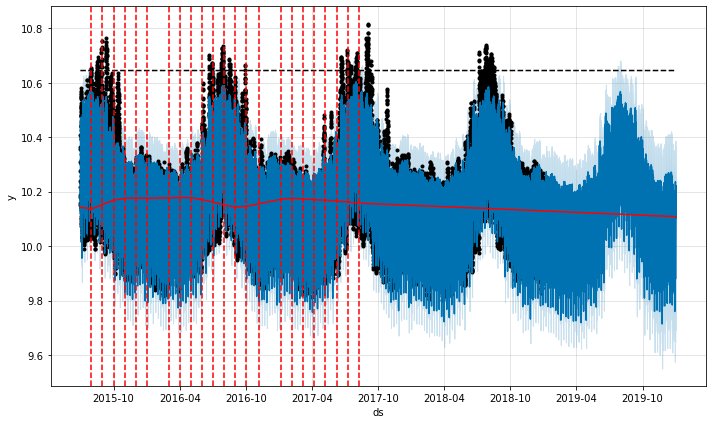

In [22]:
model = Prophet(changepoint_range=.6,weekly_seasonality=True,daily_seasonality=False,yearly_seasonality=50,
               growth='logistic')

model.add_seasonality(name='on_season_daily',period=1, condition_name='on_season',fourier_order=10,prior_scale=10)
model.add_seasonality(name='off_season_daily',period=1, condition_name='off_season',fourier_order=10,prior_scale=10)

model.fit(dd_demand_train)

future = model.make_future_dataframe(periods=365*24,freq='1H')
future['cap'] = np.log(42000)
future['on_season'] = future['ds'].apply(demand_onS)
future['off_season'] = ~ future['ds'].apply(demand_onS)
forcast = model.predict(future)

fig = model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(), model, forcast)
forcast.tail()

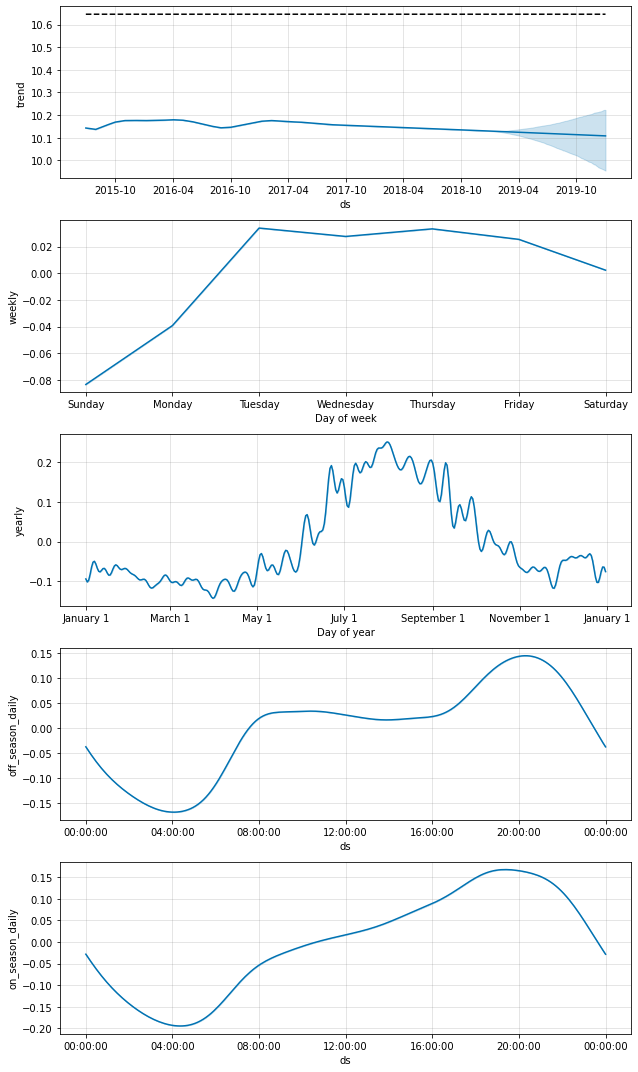

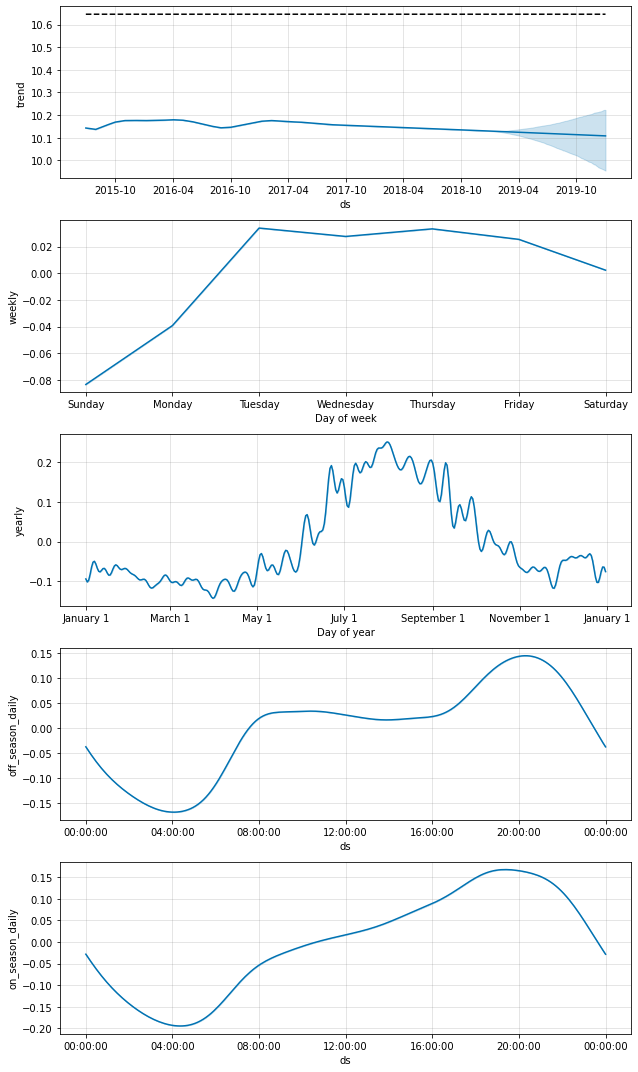

In [23]:
model.plot_components(forcast)

In [24]:
dd_demand['y'] = np.exp(dd_demand['y'])

dd_demand_train['y'] = np.exp(dd_demand_train['y'])

forcast['yhat'] = np.exp(forcast['yhat'])

dd_demand_test = dd_demand.loc[dd_demand['ds']>pd.to_datetime('01/01/2019')]



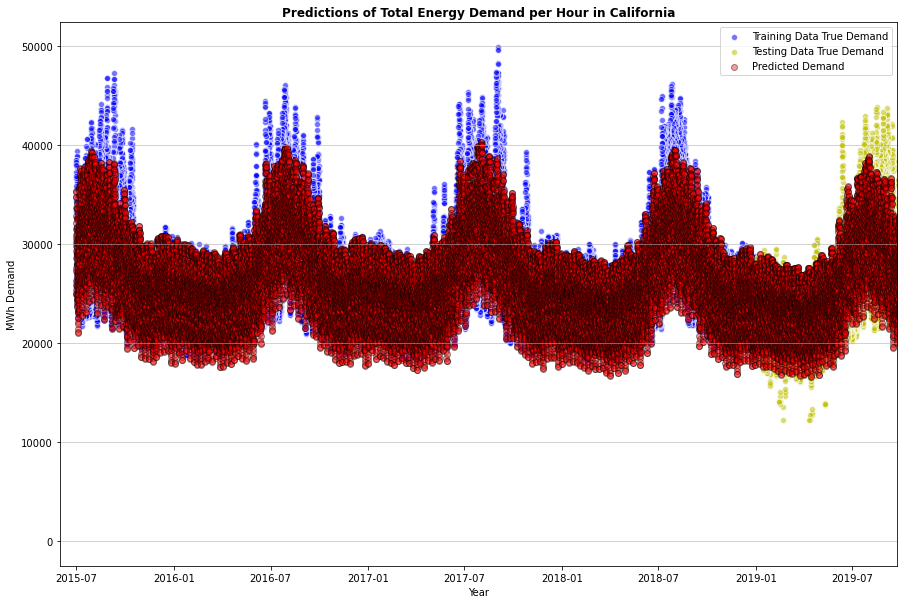

In [25]:

plt.figure(figsize=(15,10))

plt.scatter(dd_demand_train['ds'],dd_demand_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Demand')
plt.scatter(dd_demand_test['ds'],dd_demand_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Demand')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.4,edgecolor='k',label='Predicted Demand')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('09/23/2019'))
plt.ylabel('MWh Demand')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Energy Demand per Hour in California",fontweight='bold')
plt.show()



Predicted Total Demand 2019 (GWh):  211363.0
True Total Energy Demand 2019 (GWh):  202123.0
Error (GWh):  9240.0
Percent Error:  4.6 %


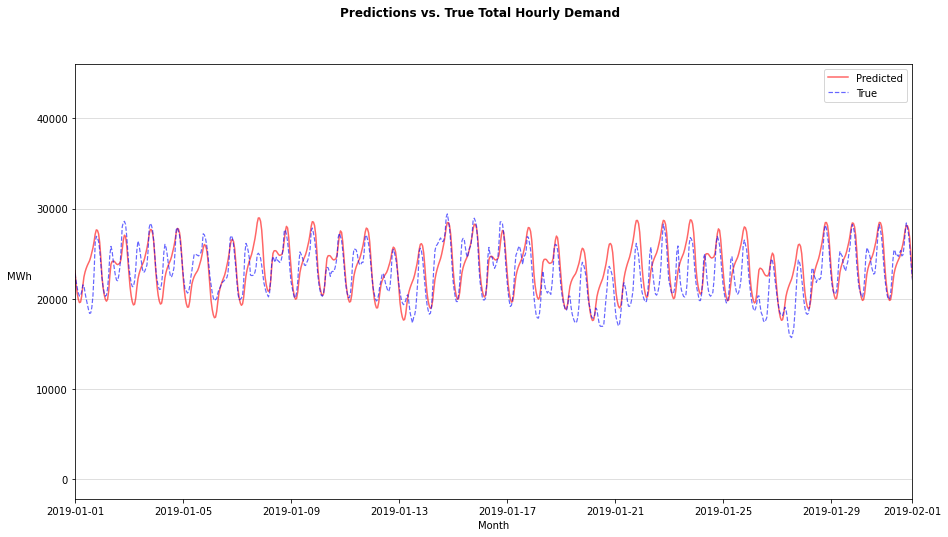

Train MAPE:  5.54 %
Train R2:  0.826161304031045
Test MAPE:  8.58 %
Test R2:  0.702025694551362


In [27]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('12/16/2019'))),['yhat','ds']])
true = pd.DataFrame(dd_demand.loc[((dd_demand['ds'] >= pd.to_datetime('01/01/2019')) & \
                                   (dd_demand['ds'] < pd.to_datetime('12/16/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),
                  how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Demand 2019 (GWh): ',(tester['yhat'].sum())//1000)
print('True Total Energy Demand 2019 (GWh): ',tester['y'].sum()//1000)
print('Error (GWh): ', (tester['yhat'].sum()-tester['y'].sum())//1000)
print('Percent Error: ', round(((tester['yhat'].sum()-tester['y'].sum())/tester['y'].sum())*100,1),'%')


dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('12/16/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('12/16/2019'))),'ds'])).\
resample('1H').sum().loc[:,'yhat'].values


datat = dd_demand.loc[((dd_demand['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd_demand['ds'] < pd.to_datetime('12/16/2019'))),:].set_index\
(pd.DatetimeIndex(dd_demand.loc[((dd_demand['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd_demand['ds'] < pd.to_datetime('12/16/2019'))),'ds'])).resample('1H').sum().loc[:,'y'].values



month_list = pd.date_range('01/01/2019','12/15/2019 23:00:00',freq='1H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.6,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Hourly Demand',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('02/01/2019'))

plt.show()

yhat_train = pd.DataFrame(forcast.loc[\
                                       (forcast['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_train = pd.DataFrame(dd_demand.loc[\
                                  (dd_demand['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])

tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
index = []
for ind,j in enumerate(true_train):
    if np.isnan(j):
        index.append(ind)
true_train, yhat_train = np.delete(true_train, index), np.delete(yhat_train, index)
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', round(mape,2),'%')
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values

yhat_test = tester['yhat'].values
indexes = []
for ind,j in enumerate(true_test):
    if np.isnan(j):
        indexes.append(ind)

yhat_test = np.delete(yhat_test, indexes)
true_test = np.delete(true_test, indexes)
        
        

mape2 = (np.sum((np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/(true))),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', round(mape2,2),'%')

print('Test R2: ',r2)
